In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import torch.nn as nn
import sys
import torch
import itertools

import numpy as np

sys.path.append('../pipeline_src/')
from dataset.dataset import HypernymDataset, Collator
from dataset.prompt_schemas import (
    hypo_term_hyper,
    predict_child_from_2_parents,
    predict_child_from_parent,
    predict_child_with_parent_and_grandparent,
    predict_children_with_parent_and_brothers,
    predict_parent_from_child_granparent,
)

from torch.utils.data import DataLoader

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TRANSFORMERS_CACHE'] = '/home/mnt/public-datasets/rabikov/hf_cache/'
os.environ['HF_HOME'] = '/home/mnt/public-datasets/rabikov/hf_cache/'

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, LlamaTokenizer, LlamaForCausalLM
import torch



In [2]:
path = 'gs_taxo/EN/environment_eurovoc_en.taxo'

In [3]:
G = nx.DiGraph()

with open(path, 'r') as f:
    for line in f:
        idx, hypo, hyper = line.split('\t')
        hyper = hyper.replace('\n', '')
        G.add_node(hypo)
        G.add_node(hyper)
        G.add_edge(hyper, hypo)

In [4]:
# G['climate change policy']
# G.number_of_edges(), G.number_of_nodes()
# list(nx.topological_sort(G))
# list(G.successors('environment'))
# G['climate']

In [5]:
len(np.unique(np.array(G.nodes())))

261

In [6]:
class PplDataset(HypernymDataset):

        def __init__(
        self,
        data,
        tokenizer,
        tokenizer_encode_args={"return_tensors": "pt"},
        transforms={
            "only_child_leaf": predict_parent_from_child_granparent,
            "only_leafs_all": predict_child_from_parent,
            "only_leafs_divided": predict_children_with_parent_and_brothers,
            "leafs_and_no_leafs": predict_child_from_parent,
            "simple_triplet_grandparent": predict_parent_from_child_granparent,
            "simple_triplet_2parent": predict_child_from_2_parents,
        },
        ):

            self.tokenizer = tokenizer
            self.tokenizer_encode_args = tokenizer_encode_args
            self.data = data
            self.case2transform = transforms


In [7]:
class PplEstimator():

    def __init__(self, model, tokenizer, batch_size=4, device='cpu'):

        self.model = model.eval()
        self.tokenizer = tokenizer
        self.bs = batch_size
        self.mask_label_token = -100
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss(reduction='none')

    def estimate_over_vertex(self, vertex, possible_verteces):
        '''
        vertex is a word = str
        possible verteces is a list of possilbe nodes 
        '''  
        loader = self.get_loader(vertex, possible_verteces)
        ppls = self.ppl_over_loader(loader)
        return ppls
        
    @torch.no_grad()
    def ppl_over_loader(self, loader):
        ppl_ls = []

        for batch in loader:
            terms, att_mask_terms, targets, input_seqs, att_mask_input, labels = batch
            output = self.model.forward(
                input_seqs.to(self.device).long(),
                attention_mask=att_mask_input.to(self.device).long(),
                labels=labels.to(self.device).long(),
            )

            losses = self.loss_fn(output['logits'].transpose(1,2), input_seqs)
            ppl = ((losses * (labels != -100)).sum(dim=1) / (labels != -100).sum(dim=1)).exp()
            ppl_ls.extend(ppl.cpu().tolist())

        return ppl_ls



    def get_loader(self, vertex, possible_verteces):
        '''
        return DataLoader object
        '''
        
        cased_list = self.get_cased_list(vertex, possible_verteces)
        dataset = PplDataset(cased_list, self.tokenizer)
        collator = Collator(
                self.tokenizer.eos_token_id, self.tokenizer.eos_token_id, self.mask_label_token
            )

        return DataLoader(
            dataset,
            batch_size=self.bs,
            collate_fn=collator,
            shuffle=True,
            num_workers=1,
            drop_last=False,
            pin_memory=False,
        )
    def get_cased_list(self, vertex, possible_verteces):
        '''
        returns list of cased samples
        '''
        ls = []
        for v in possible_verteces:
            elem = {}
            elem["children"] = v
            elem["parents"] = vertex
            elem["grandparents"] = None
            elem["case"] = "leafs_and_no_leafs"

            ls.append(elem)

        return ls   

In [8]:
model_id = "EleutherAI/gpt-neo-125m"
#model_id = 'meta-llama/Llama-2-7b-hf'

model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id)


In [9]:
ppl_est = PplEstimator(model, tokenizer)

In [10]:
len(G.nodes())

261

In [11]:
all_pairs = itertools.permutations(G.nodes(), 2)
len(list(all_pairs)) / 32

2120.625

In [12]:
ls = [0, 2, 5, 10, -1, 4]

In [14]:
top_edges_idx = np.argsort(ls)[:min(5, len(ls))]

In [15]:
top_edges_idx

array([4, 0, 1, 5, 2])

In [20]:
np.random.rand(5)

array([0.695544  , 0.27525812, 0.31240542, 0.64126822, 0.39969971])

In [30]:
all_edges = []

def build_tree(root, possible_verteces):
    ppls = np.random.rand(len(possible_verteces))#ppl_est.estimate_over_vertex(root, possible_verteces)
    
    top_edges_idx = np.argsort(ppls)[:min(5, len(ppls))]
    new_pos_verteces = np.delete(possible_verteces, top_edges_idx)
    for new_edge_idx in top_edges_idx:
        all_edges.append((root, possible_verteces[new_edge_idx]))
        build_tree(possible_verteces[new_edge_idx], new_pos_verteces)

In [31]:
all_verteces = ['very strange cat', 'dog', 'big scary shark', 'fluffy rabbit']
root = 'environment'

build_tree(root, all_verteces)

In [32]:
all_edges

[('environment', 'fluffy rabbit'),
 ('environment', 'dog'),
 ('environment', 'very strange cat'),
 ('environment', 'big scary shark')]

In [27]:
ppls = ppl_est.estimate_over_vertex('environment', ['very strange cat', 'dog', 'big scary shark', 'fluffy rabbit'])

In [28]:
ppls

[5474.2890625, 6872.369140625, 9663.1591796875, 7053.33349609375]

In [8]:
loader = ppl_est.get_loader('environment', ['very strange cat', 'dog', 'big scary shark', 'fluffy rabbit'])

In [9]:
for batch in loader:
    terms, att_mask_terms, targets, input_seqs, att_mask_input, labels = batch

In [10]:
output = model.forward(
                input_seqs.long(),
                attention_mask=att_mask_input.long(),
                labels=labels.long(),
            )

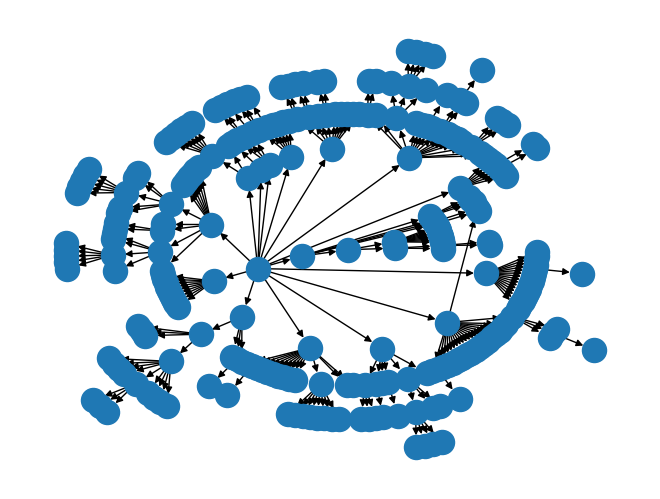

In [9]:
pos = graphviz_layout(G, prog="twopi")
nx.draw(G, pos)
plt.show()


In [14]:
max(list(map(lambda x: x[1], G.in_degree())))

2

In [17]:
np.array(list(map(lambda x: x[1], G.in_degree())))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])